In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import psutil


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB, ThompsonSampling
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

from modified_ips import Exp_Smooth_IPS_Min, Exp_Smooth_IPS_Max

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/30 16:48:59 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/09/30 16:48:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/30 16:49:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/30 16:49:00 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")

Оставим только 300 самых популярных айтемов

In [6]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:300]['item_id'].tolist()
# popular_items = logs['item_id'].tolist()

In [7]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (389735, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [8]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6039, 5), (300, 3))

In [9]:
dataset = MovielensBanditDataset(data)

30-Sep-24 16:49:02, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


30-Sep-24 16:49:06, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
30-Sep-24 16:49:07, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model


In [10]:
def optimize_ope_parameters(learner_action_dist, lambda_s, beta_1s, beta_2s, k=20000):
    CIPS_MSE = []
    for lambda_ in lambda_s:
        ope = InverseProbabilityWeighting(lambda_=lambda_, estimator_name='cips')
        CIPS_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(CIPS_MSE))
        best_lambda_ = lambda_s[best_idx]
        # print(np.array(CIPS_MSE)[best_idx])
        
    
    ESIPSMAX_MSE = []
    for beta_1 in beta_1s:
        ope = Exp_Smooth_IPS_Max(beta = beta_1)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_1 = beta_1s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    ESIPSMAX_MSE = []
    for beta_2 in beta_2s:
        ope = Exp_Smooth_IPS_Max(beta = beta_2)
        ESIPSMAX_MSE.append(ope._estimate_mse_score(
            reward=bandit_feedback_test['reward'][:k],
            action=bandit_feedback_test['action'][:k],
            pscore=bandit_feedback_test['pscore'][:k],
            action_dist=learner_action_dist[:k],
            position=bandit_feedback_test['position'][:k],
            use_bias_upper_bound = False))
        best_idx = np.argmin(np.array(ESIPSMAX_MSE))
        best_beta_2 = beta_2s[best_idx]
        # print(np.array(ESIPSMAX_MSE)[best_idx])
        
    return {'lambda_':best_lambda_, 'beta_1': best_beta_1, 'beta_2': best_beta_2}

In [11]:
dict_opt_algo = {    
    'UCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'Random': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
    
    'Lin-UCB': {'lambda_s': [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 5, 6, 7, 8, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 50, 55, 60, 65, 70, 71, 75, 79, np.inf], 
                 'beta_1s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1], 
                 'beta_2s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]},
}

In [12]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j] = action_dist
    return all_action_dist

In [13]:
def run_exp(learner_action_dist, lambda_, beta_1, beta_2):
    Vs = []
    CIs = []

    for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, bandit_feedback_test['n_rounds']]:
    # for n_size in [50000, 100000, 150000, 200000, 250000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),
                            Exp_Smooth_IPS_Max(beta = beta_1), Exp_Smooth_IPS_Min(beta = beta_2), InverseProbabilityWeighting(lambda_ = lambda_, estimator_name='cips')]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        
        action_dist = learner_action_dist[:n_size, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=100,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [14]:
import warnings
warnings.filterwarnings("ignore")

Подсчет Vs, CIs для разного числа негативных семплов для LinUCB:

In [15]:
dataset.user_features.toPandas()

,user_idx,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_<20,gender_F,gender_M,occupation_0,occupation_1,...,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,3922,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2360,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3573,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4884,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2051,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,155,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6035,1463,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,5714,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,3271,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

In [17]:
bandit_feedback_test['log'].toPandas()['timestamp'].tolist()[0]

Timestamp('2000-11-21 11:10:18')

In [18]:
sorted(bandit_feedback_train['log'].toPandas()['timestamp'].tolist())[-1]

Timestamp('2000-11-21 11:10:05')

In [19]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

np.save('estimated_rewards_by_reg_model.npy', estimated_rewards_by_reg_model)
estimated_rewards_by_reg_model = np.load('estimated_rewards_by_reg_model.npy')

In [20]:
# # n_negatives = [0, 50, 100, 150, 200, 250, 300, 350, 400]
# n_negatives = [250]

# for n_neg in n_negatives:
#     print('n_neg:', n_neg)
#     print(1, 'momory usage:', psutil.virtual_memory().percent)
#     bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True, n_neg=n_neg)
#     print(2, 'momory usage:', psutil.virtual_memory().percent)
        
#     model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
#     learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                         replay_model=model_2)
#     learner_2.fit(bandit_feedback_train)
#     print(3, 'momory usage:', psutil.virtual_memory().percent)
    
#     # learner_action_dist_2 = get_dist(learner_2)
    
#     # np.save(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy', learner_action_dist_2)
#     learner_action_dist_2 = np.load(f'./Vs_CIs/learner_action_dist_2_{n_neg}.npy')
    
#     print(4, 'momory usage:', psutil.virtual_memory().percent)
    
#     opt_params_ips_2 = optimize_ope_parameters(learner_action_dist_2, dict_opt_algo['Lin-UCB']['lambda_s'], dict_opt_algo['Lin-UCB']['beta_1s'], dict_opt_algo['Lin-UCB']['beta_2s'])
#     print(opt_params_ips_2)
    
#     print(5, 'momory usage:', psutil.virtual_memory().percent)
    
#     Vs_2, CIs_2 = run_exp(learner_action_dist_2, opt_params_ips_2['lambda_'], opt_params_ips_2['beta_1'], opt_params_ips_2['beta_2'])
    
#     np.save(f'./Vs_CIs/Vs_2_opt_{n_neg}.npy', Vs_2)
#     np.save(f'./Vs_CIs/CIs_2_opt_{n_neg}.npy', CIs_2)
#     print('Vs:', Vs_2[-1])
#     print('CIs:', CIs_2[-1])

UCB:

In [21]:
print('momory usage:', psutil.virtual_memory().percent)
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print('train_size:', bandit_feedback_train["n_rounds"])
print('test_size:', bandit_feedback_test["n_rounds"])
    
model_1 = UCB(exploration_coef = 0.01, sample = True, seed = 123)
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1)
learner_1.fit(bandit_feedback_train)

learner_action_dist_1 = get_dist(learner_1)

opt_params_ips_1 = optimize_ope_parameters(learner_action_dist_1, dict_opt_algo['UCB']['lambda_s'], dict_opt_algo['UCB']['beta_1s'], dict_opt_algo['UCB']['beta_2s'])
print(opt_params_ips_1)

print('momory usage:', psutil.virtual_memory().percent)

Vs_1, CIs_1 = run_exp(learner_action_dist_1, opt_params_ips_1['lambda_'], opt_params_ips_1['beta_1'], opt_params_ips_1['beta_2'])

np.save(f'./Vs_CIs/Vs_1_opt_{0}.npy', Vs_1)
np.save(f'./Vs_CIs/CIs_1_opt_{0}.npy', CIs_1)
print('Vs:', Vs_1[-1])
print('CIs:', CIs_1[-1])

momory usage: 19.2
train_size: 272814
test_size: 116921


100%|██████████| 390/390 [01:14<00:00,  5.27it/s]


{'lambda_': 2, 'beta_1': 1, 'beta_2': 1}
momory usage: 21.5
n_size = 10000 time:  0.2087242603302002
n_size = 20000 time:  0.35932183265686035
n_size = 30000 time:  0.39600181579589844
n_size = 40000 time:  0.6599392890930176
n_size = 50000 time:  0.6767599582672119
n_size = 60000 time:  0.72117018699646
n_size = 70000 time:  1.2147328853607178
n_size = 80000 time:  1.262704610824585
n_size = 90000 time:  1.2793278694152832
n_size = 100000 time:  1.3133249282836914
n_size = 110000 time:  1.3495111465454102
n_size = 116921 time:  1.359591007232666
Vs: {'ipw': 0.915853680772732, 'dm': 0.9063334558141214, 'sndr': 0.9011282843968118, 'snipw': 0.9010273227190392, 'ESIPSMAX': 0.915853680772732, 'ESIPSMIN': 0.915853680772732, 'cips': 0.9158047803091275}
CIs: {'ipw': {'mean': 0.9156946174039569, '95.0% CI (lower)': 0.9132860626882853, '95.0% CI (upper)': 0.9184284623960143}, 'dm': {'mean': 0.9063330105491708, '95.0% CI (lower)': 0.906288217645985, '95.0% CI (upper)': 0.9063819846718812}, 'sndr

In [22]:
learner_action_dist_1.shape

(116921, 300, 1)

In [23]:
actions = bandit_feedback_test['action']
p_new = learner_action_dist_1[np.arange(actions.shape[0]), actions][:, 0]
p_old = bandit_feedback_test['pscore']

In [24]:
p_old.shape, p_new.shape, actions.shape

((116921,), (116921,), (116921,))

In [25]:
w = p_new/p_old

In [26]:
r = np.array(bandit_feedback_test['log'].toPandas()['relevance'].tolist())

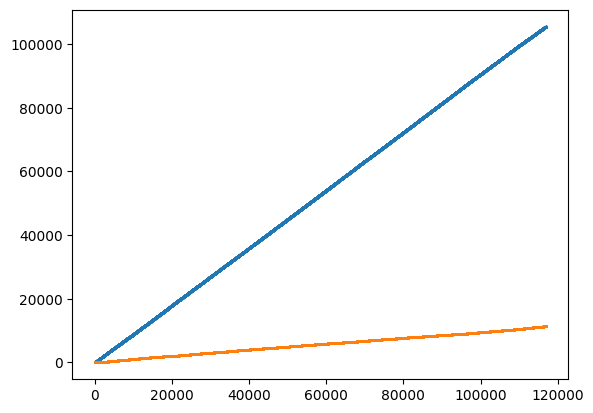

In [27]:
plt.scatter(np.arange(bandit_feedback_test['n_rounds']), np.cumsum(r==1), s = 0.1)
plt.scatter(np.arange(bandit_feedback_test['n_rounds']), np.cumsum(r==0), s = 0.1)

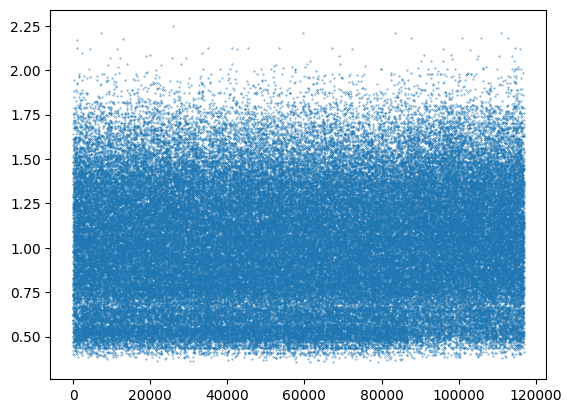

In [28]:
plt.scatter(np.arange(bandit_feedback_test['n_rounds']), w, s = 0.1)

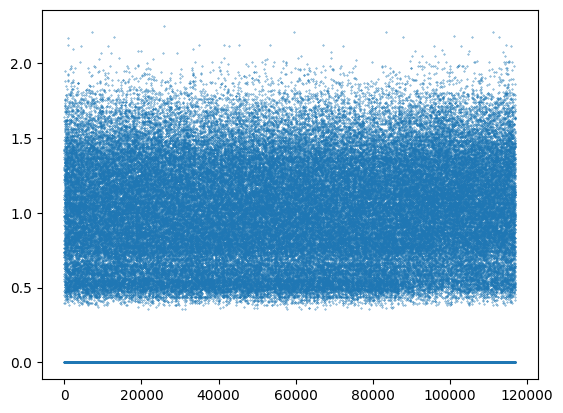

In [29]:
plt.scatter(np.arange(bandit_feedback_test['n_rounds']), r*w, s = 0.1)

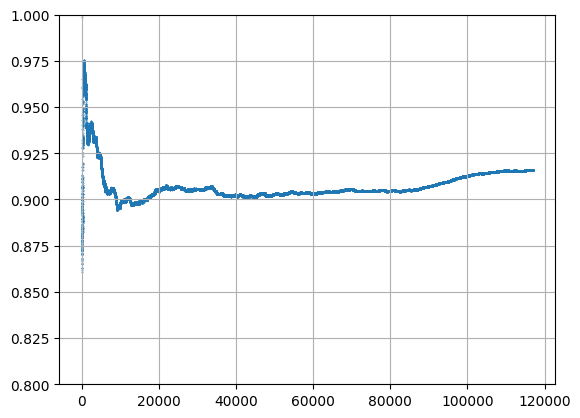

In [30]:
plt.scatter(np.arange(bandit_feedback_test['n_rounds']), np.cumsum(r*w)/np.arange(1, bandit_feedback_test['n_rounds']+1), s = 0.1)
plt.grid()
plt.ylim([0.8, 1])
plt.show()

Random:

In [31]:
# print('momory usage:', psutil.virtual_memory().percent)
# bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

# print('train_size:', bandit_feedback_train["n_rounds"])
# print('test_size:', bandit_feedback_test["n_rounds"])
    
# model_3 = RandomRec(seed=42)
# learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_3)
# learner_3.fit(bandit_feedback_train)

# learner_action_dist_3 = get_dist(learner_3)

# opt_params_ips_3 = optimize_ope_parameters(learner_action_dist_3, dict_opt_algo['Random']['lambda_s'], dict_opt_algo['Random']['beta_1s'], dict_opt_algo['Random']['beta_2s'])
# print(opt_params_ips_3)
# print('momory usage:', psutil.virtual_memory().percent)

# Vs_3, CIs_3 = run_exp(learner_action_dist_3, opt_params_ips_3['lambda_'], opt_params_ips_3['beta_1'], opt_params_ips_3['beta_2'])

# np.save(f'./Vs_CIs/Vs_3_opt_{0}.npy', Vs_3)
# np.save(f'./Vs_CIs/CIs_3_opt_{0}.npy', CIs_3)
# print('Vs:', Vs_3[-1])
# print('CIs:', CIs_3[-1])

### Теперь строим графики:

In [32]:
# estimated_rewards_by_reg_model = np.load('estimated_rewards_by_reg_model.npy')

In [31]:
ucb_v = np.load('./Vs_CIs/Vs_1_opt_0.npy', allow_pickle=True)
ucb_ci = np.load('./Vs_CIs/CIs_1_opt_0.npy', allow_pickle=True)

# linucb_v = np.load('./Vs_CIs/Vs_2_opt_0.npy', allow_pickle=True)
# linucb_ci = np.load('./Vs_CIs/CIs_2_opt_0.npy', allow_pickle=True)

# linucb_v_250 = np.load('./Vs_CIs/Vs_2_opt_250.npy', allow_pickle=True)
# linucb_ci_250 = np.load('./Vs_CIs/CIs_2_opt_250.npy', allow_pickle=True)

# random_v = np.load('./Vs_CIs/Vs_3_opt_0.npy', allow_pickle=True)
# random_ci = np.load('./Vs_CIs/CIs_3_opt_0.npy', allow_pickle=True)

In [32]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(7, figsize=(10, 10))

    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, bandit_feedback_test['n_rounds']]
    # x = [50000, 100000, 150000, 200000, 250000, 282099]
    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()
    plt.tight_layout()

In [33]:
# plot_disjoint_res(ucb_v, ucb_ci, 'UCB')

In [34]:
# plot_disjoint_res(linucb_v, linucb_ci, 'LinUCB')

In [35]:
# def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
#     fig, ax = plt.subplots(7, figsize=(10, 15))
#     x = [50000, 100000, 150000, 200000, 250000, 282099]
#     colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
#     i=0
#     for name in ['ipw', 'dm', 'sndr', 'snipw', 'ESIPSMAX',  'ESIPSMIN', 'cips']:
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

#         ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
#         y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
#         y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
#         y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

#         ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
#         ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
#         ax[i].set_title(name)
        
#         i = i+1
#     fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
#     fig.legend()
#     plt.tight_layout()

In [36]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    # x = [50000, 100000, 150000, 200000, 250000, 282099]
    x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, bandit_feedback_test['n_rounds']]
    colors = ['b', 'r', 'g', 'y', 'aqua', 'pink', 'orange']
    i = 0
    for name in ['ipw', 'dm']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

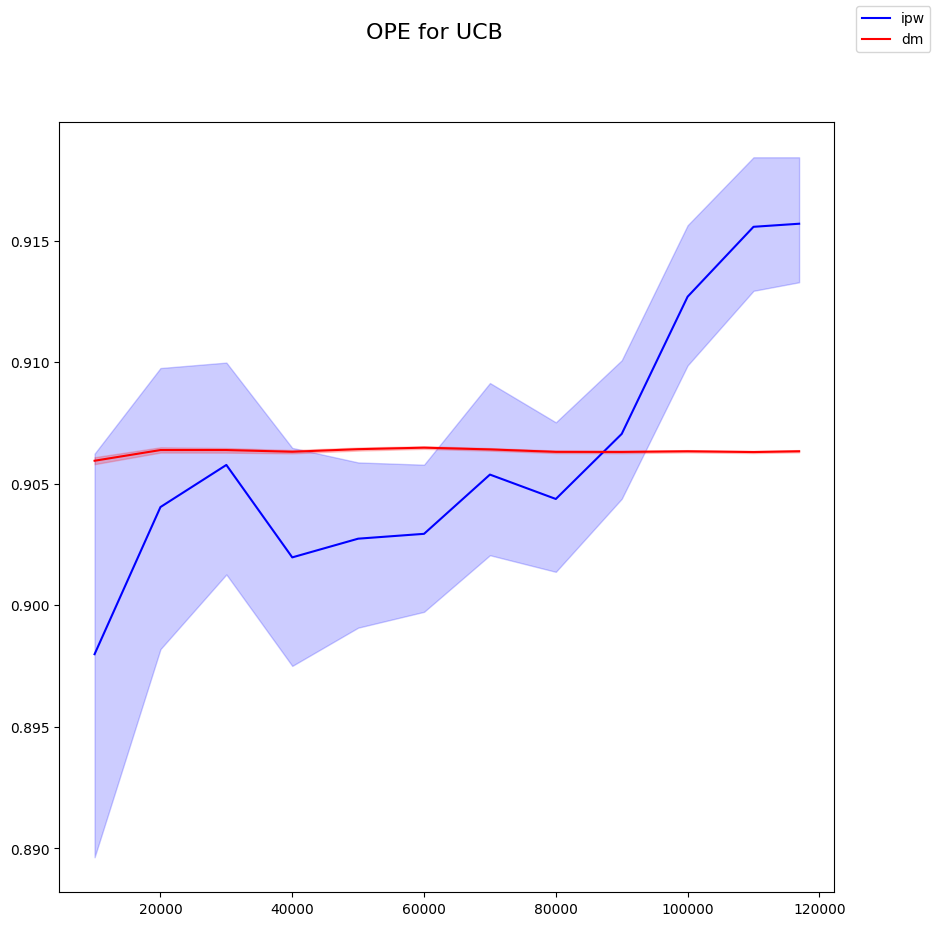

In [37]:
plot_join_res(ucb_v, ucb_ci, 'UCB')

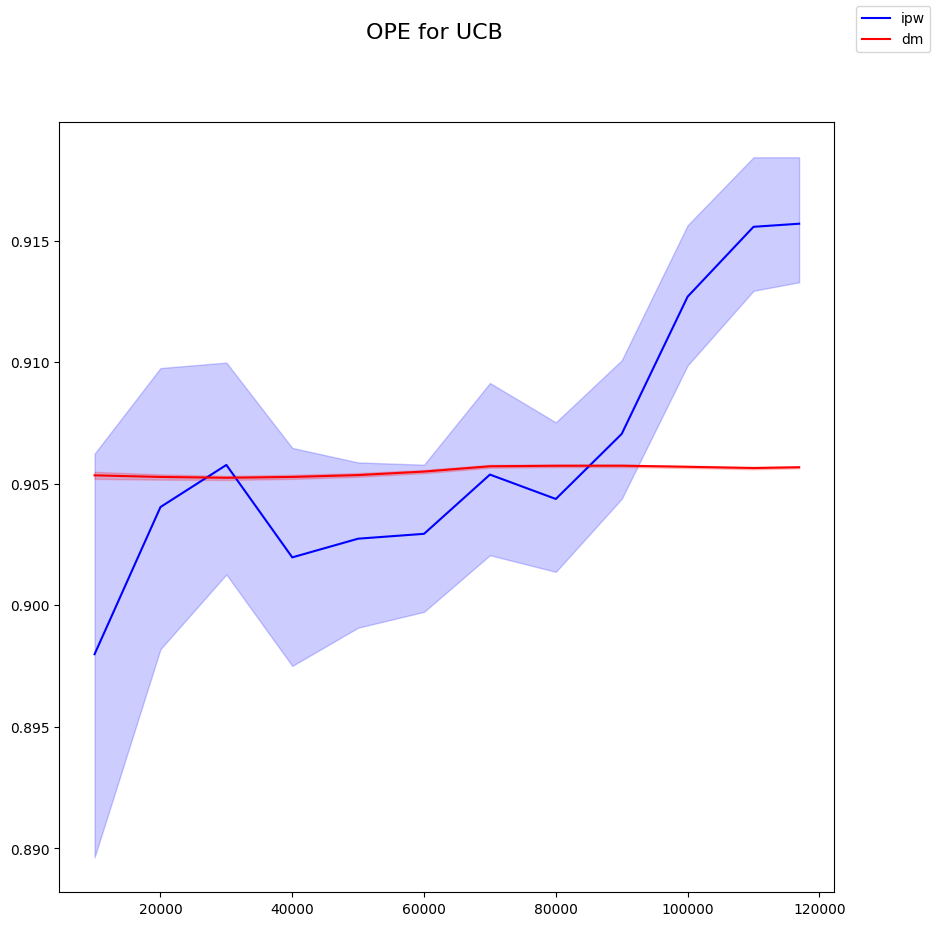

In [39]:
plot_join_res(ucb_v, ucb_ci, 'UCB')

In [39]:
# plot_join_res(linucb_v, linucb_ci, 'linucb')

In [40]:
# plot_join_res(linucb_v_250, linucb_ci_250, 'linucb-250neg')

In [41]:
# plot_join_res(random_v, random_ci, 'random')